# Learning goals
After this week's lesson you should be able to:
- Perform an overlay analysis
- Reclassify data
- Perform a spatial join (Refresher)

This week's lessons are adapted from:
- [Automating GIS Processes Lesson 3](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-3/overview.html)
- [Automating GIS Processes Lesson 4](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/overview.html)

In [1]:
# We are going to start importing the libraries we need
# all in one cell. 
# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import os
os.getcwd()

'/Users/wenfeixu/Documents/GITHUB/4680_5680_intro_uds/Week3'

# 1. Overlay Analysis
Overlay analyses are GIS operations in which two or more vector layers are combined to produce new geometries. Typical overlay operations include union, intersection, and difference - named after the result of the combination of two layers.

</figure>
<img src="https://autogis-site.readthedocs.io/en/latest/_images/overlay-operations_700x200px.svg" alt="drawing" width="700" style="display: block; margin: 0 auto"/>
</figure>

## 1.1 Loading data
Let's say we wanted to study which [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz) in NYC are more vulnerable to flooding. Here, we will measure vulnerability as the areal coverage of the neighborhood by the [NYC Stormwater Flood Map](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd). 

Let's download two datasets and put it into our current folder: 
- The [Neighborhood Tabulation Areas](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz) (make sure to download the shapefile)
- [NYC Stormwater Flood Map - Moderate Flood with 2050 Sea Level Rise](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd) There is a zip file in on this page and you will have to unzip to read a `.gdb` file

In [2]:
nta = gpd.read_file('NTA map.zip')

In [3]:
nta.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."


<AxesSubplot:>

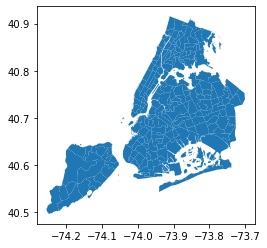

In [4]:
nta.plot()

In [47]:
## I'm sorry this file is a pain 
## It is a .gdb file, which is a geodatabase file in ArcGIS
## It only has one layer, so we can just read it in with layer=0
## We can also use the driver='FileGDB' to tell geopandas that it is a geodatabase file
## Though Geopandas will infer the file format from the file extension, so we don't need to specify the driver 



# flood_2050 = gpd.read_file("NYC_Stormwater_Flood_Map_-_Moderate_Flood_with_2050_Sea_Level_Rise/NYC Stormwater Flood Map - Moderate Flood with 2050 Sea Level Rise.gdb",
#                         driver='FileGDB', 
#                         layer=0)

flood_2050 = gpd.read_file('flood_2050.geojson',driver='GeoJSON')

# And this file name is terrible. 
# Ok enough griping. 

In [49]:
flood_2050

,Flooding_C,Shape_Leng,Shape_Area,geometry
0,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((917232.601 120841.554 0.000,..."
1,2,2.877719e+06,4.613496e+07,"MULTIPOLYGON Z (((917155.062 120828.741 0.000,..."
2,3,4.994691e+06,1.389420e+08,"MULTIPOLYGON Z (((915689.174 120243.672 0.000,..."


In [50]:
flood_2050.to_file('flood_2050.geojson',driver='GeoJSON')

In [13]:
flood_2050 = flood_2050.rename(columns={'Flooding_C':'Flooding_Category'})

In [14]:
flood_2050.head()

,Flooding_Category,Shape_Leng,Shape_Area,geometry
0,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((917232.601 120841.554 0.000,..."
1,2,2.877719e+06,4.613496e+07,"MULTIPOLYGON Z (((917155.062 120828.741 0.000,..."
2,3,4.994691e+06,1.389420e+08,"MULTIPOLYGON Z (((915689.174 120243.672 0.000,..."


This is unusual. There are only three rows in the dataset! Judging by the `Flooding_Category` column an the fact that each entry in the `geometry` column is a **MULTIPOLYGON** (we're going to ignore the Z part. This is actually a 3D polygon, but we won't work with the third dimension in this example.)

Looking, in the data dictionary for the flood data, which should be the `.xlsx` file in the unzipped folder we can see that these are the following categories definitions: 
- 1 - Nuisance Flooding (greater or equal to 4 in. and less than 1 ft.)
- 2 - Deep and Contiguous Flooding (1 ft. and greater)
- 3 - Future High Tides 2050

I'm going to make a quick categorical plot to get a sense of what the data may look like. 

<AxesSubplot:>

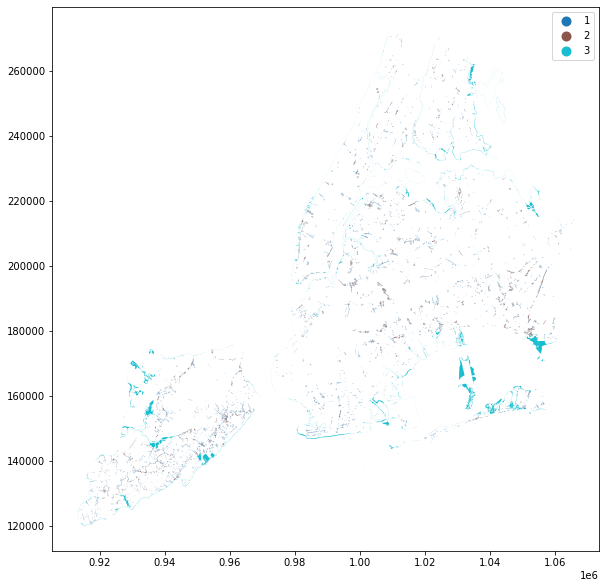

In [15]:
flood_2050.plot('Flooding_Category',
                figsize=(10,10),
                legend=True,
                categorical=True)

For now, let's just use **Category 1 "Nuisance Flooding"** to simplify this calculation. I'm going to create a new gdf called `flood_2050_cat1` 

In [17]:
flood_2050['Flooding_Category'] == 1

0     True
1    False
2    False
Name: Flooding_Category, dtype: bool

In [16]:
flood_2050_cat1 = flood_2050[flood_2050['Flooding_Category'] == 1]

## 1.2 `.overlay()`
We'll want to estimate the **percentage of the neighborhood at risk of category 1 flooding**. The first step is to do the following: 
1. Check the CRS between our two layers to make sure they are the same. 
2. Find the **Intersection** of geometries, using the `.overlay()`, function between the neighborhoods and the flood zones: That is we'll want to find the shapes that overlap between the neighborhood and each flood zone. 

In [18]:
nta.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
flood_2050_cat1.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Looks like they are different: 
- `nta` is **EPSG:4326**
- `flood_2050` is **EPSG:2263**

Notice that EPSG:2263 is in **feet**. Again, whenever we want to estimate areas, volumes, or lengths, we'll want to do this in a CRS in a unit that we can understand. (Areas in degrees doesn't make too much sense.) 

For now, let's convert the `nta` to **EPSG:2263** to have our measurements in **feet**. I'm going to create a new gdf `nta_2263`. 

In [20]:
nta_2263 = nta.to_crs(flood_2050_cat1.crs)

Finally, I want to create this overlay and assign it to a new gdf called `nta_2263_overlay_flood`. Note: This may take little bit of time as the `.overlay()` function is calculating all possible matches. Between geometries in `nta_2263` and `flood_2050_cat1`. (It took about 45 seconds on my computer.)

In [22]:
nta_2263_overlay_flood = gpd.overlay(nta_2263,flood_2050_cat1,how='intersection')

In [23]:
nta_2263_overlay_flood.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,Flooding_Category,Shape_Leng,Shape_Area,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((995786.172 161696.399 0.000,..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1000658.411 187920.156 0.000...
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1013101.766 251151.847 0.000...
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((991114.729 163623.486 0.000,..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1004922.704 174134.283 0.000...


## Q.1 Groupby-and-summarize (5 pts)
How many rows for each neighborhood are there? `nta_2263_overlay_flood`? 

In [ ]:
## insert your code here

Let's take a look at what resulted. We can see here that we have columns from both the neighborhoods and flood gdfs. 

In [24]:
nta_2263_overlay_flood.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,Flooding_Category,Shape_Leng,Shape_Area,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((995786.172 161696.399 0.000,..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1000658.411 187920.156 0.000...
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1013101.766 251151.847 0.000...
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((991114.729 163623.486 0.000,..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1004922.704 174134.283 0.000...


<AxesSubplot:>

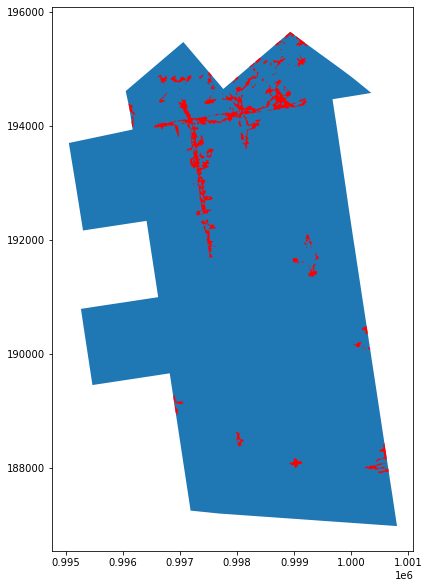

In [26]:
## I'm just going to select one neighborhood and see what this overlay looks like
fig1, ax1 = plt.subplots(1,1,figsize=(10,10))

## Plotting the neighborhood BK43
nta_2263[nta_2263['ntacode']=='BK75'].plot(ax=ax1)

## Plotting the flood zone intersecting with the neighborhood
nta_2263_overlay_flood[nta_2263_overlay_flood['ntacode']=='BK75'].plot(ax=ax1,color='red')

## 1.3 Find area percentage
For all neighborhoods, I'll want to find: 
$$
\% floodzone_{n} =\frac{A_{fn}}{A_{n}}
$$

where $n$ is a neighborhood, $A_{fn}$ is the area of the flood zone that intersects with that neighborhood $n$ and $A_n$ is the area of the neighorhood.

(Yes we can write mathematical notation in Markdown using LaTex! No, I won't make you do it if you aren't already familiar with LaTex.)

To do this, we'll need: 
- $A_{fn}$ 
- $A_n$

In [27]:
nta_2263_overlay_flood.area

0      1.721683e+05
1      8.531479e+05
2      1.342532e+04
3      1.227249e+05
4      5.822751e+05
           ...     
186    7.789327e+04
187    5.551872e+05
188    6.423526e+05
189    1.106660e+06
190    1.109868e+05
Length: 191, dtype: float64

In [28]:
nta_2263_overlay_flood['area_flood'] = nta_2263_overlay_flood.area
nta_2263['area_neighb'] = nta_2263.area

In [30]:
nta_2263_overlay_flood.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,Flooding_Category,Shape_Leng,Shape_Area,geometry,area_flood
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((995786.172 161696.399 0.000,...",172168.347800
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1000658.411 187920.156 0.000...,853147.927615
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1013101.766 251151.847 0.000...,13425.316076
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((991114.729 163623.486 0.000,...",122724.913643
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1004922.704 174134.283 0.000...,582275.116554


## 1.4 Merge
I'm now going merge my `nta_2263_overlay_flood` gdf with the `nta_2263` because I want to divide `area_flood` and `area_neighb`. 
 

In [32]:
## Again I'm just going to select the two columns I need, the neighborhood code (to perform the merge) 
## and the area of the flood zone (to calculate the percentage of the neighborhood that is flooded)
## I'm going to use a left join, so that I keep all the neighborhoods in the original dataset, 
## even if they don't intersect with the flood zone dataset

nta_2263_merged = nta_2263.merge(nta_2263_overlay_flood[['ntacode','area_flood']],
                                 left_on='ntacode',
                                 right_on='ntacode',how='left')

Super! 

In [33]:
nta_2263_merged.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.830 168503.270, 998996.914 16...",3.579975e+07,172168.347800
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.288 194575.097, 999670.058 1...",3.262995e+07,853147.927615
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.095 253237.163, 1014382.976 ...",6.307283e+06,13425.316076
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.911 169268.253, 990588.262 16...",5.400519e+07,122724.913643
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.380 176865.949, 1009376.485 ...",3.270704e+07,582275.116554


## 1.5 Calculate percentage
Lastly, we'll just have to calculate the percentage of the flood zone in each neighborhood. 


In [34]:
nta_2263_merged['perc_flood'] = nta_2263_merged['area_flood'] / nta_2263_merged['area_neighb']

<AxesSubplot:>

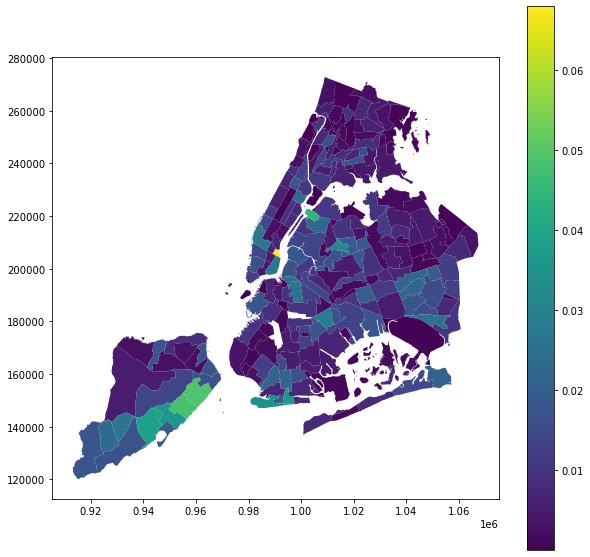

In [35]:
nta_2263_merged.plot(column='perc_flood', 
                        legend=True,
                        figsize=(10,10))

## Q.2 - Topical Knowledge (5 pts)
Here we used flood zone coverage in a neighborhood as proxy for flood. Why might this be an inexact estimate of flood risk? Propose and describe at least three factors we may not have considered in this analysis. 

## 1.5 Re-classifying data
Now, instead of using the `perc_flood` column, I want to translate the values in this column into categories that might be more meaningful to a general audience. 

- We might consider binning our values into "Low", "Average", and "High" risk categories. How to determine these? The best approach is have some topical knowledge. For instance, we might read from research reports, look at previous flooding records of these neigbhohoods, etc, to acquire an understanding of how to bin values. 
- A less informed strategy could be to categorize by the distribution of our data. 

We'll take a the less informed strategy here for the sake of time: 

In [36]:
## Remember that the describe function gives us some basic statistics about the data
nta_2263_merged['perc_flood'].describe()

count    191.000000
mean       0.011292
std        0.010103
min        0.000019
25%        0.004068
50%        0.008489
75%        0.016423
max        0.067996
Name: perc_flood, dtype: float64

From the above, we'll use the following criteria: 
- Less than 25th percentile = Low
- 25-75th percentile = Average
- 75th percentile or higher = High

To express this in code. We will: 
- Create a new empty column 
- Filter our gdf based on each criteria
- Assign a different category to each criteria. 

### 1.5.1
First, let's create an empty string column.

In [37]:
# Remember that "" is an empty string
nta_2263_merged['risk_categories'] = ""

See that we have a column called `risk_categories` that contains empty strings (note: not the same as `NaN`)

In [38]:
nta_2263_merged.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood,perc_flood,risk_categories
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.830 168503.270, 998996.914 16...",3.579975e+07,172168.347800,0.004809,
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.288 194575.097, 999670.058 1...",3.262995e+07,853147.927615,0.026146,
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.095 253237.163, 1014382.976 ...",6.307283e+06,13425.316076,0.002129,
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.911 169268.253, 990588.262 16...",5.400519e+07,122724.913643,0.002272,
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.380 176865.949, 1009376.485 ...",3.270704e+07,582275.116554,0.017803,


### 1.5.2 
Now we'll filter for each criteria

In [43]:
## I'm going to use .loc instead of the square bracket method to select the rows and columns I want to edit
## Remember that .loc is used to select rows and columns by label

## So I simultaneously select my filtering criteria for rows and the column I want to edit. 
## 0.004067 is the 25th percentile of the data
nta_2263_merged.loc[nta_2263_merged['perc_flood']<0.004067,'risk_categories'] = 'low'

## A lot of things are happening here: 
## 1. We're filtering for two conditions: Both >=25% and <=75% 
## 2. Because I have multiple conditions, I need to use the & operator to combine them 
## and use the () on each condition
## 3. I'm breaking up my code into multiple lines for readability with the \ character
nta_2263_merged.loc[(nta_2263_merged['perc_flood']>=0.004067)&\
                    (nta_2263_merged['perc_flood']<=0.016422),'risk_categories'] = 'average'

## Always make sure that you're not double counting your rows
## If you use a <=X condition, you'll need to use a >X condition
nta_2263_merged.loc[nta_2263_merged['perc_flood']>0.016422,'risk_categories'] = 'high'

In [44]:
nta_2263_merged.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood,perc_flood,risk_categories
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.830 168503.270, 998996.914 16...",3.579975e+07,172168.347800,0.004809,average
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.288 194575.097, 999670.058 1...",3.262995e+07,853147.927615,0.026146,high
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.095 253237.163, 1014382.976 ...",6.307283e+06,13425.316076,0.002129,low
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.911 169268.253, 990588.262 16...",5.400519e+07,122724.913643,0.002272,low
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.380 176865.949, 1009376.485 ...",3.270704e+07,582275.116554,0.017803,high


<AxesSubplot:>

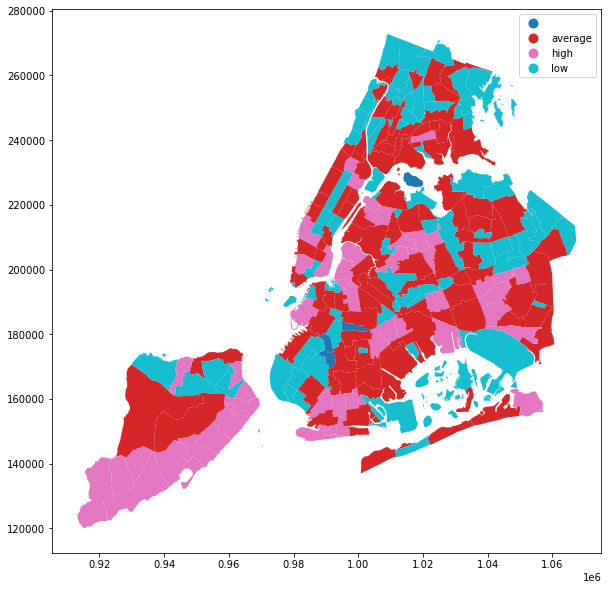

In [45]:
nta_2263_merged.plot(column='risk_categories', 
                        legend=True,
                        categorical=True,
                        figsize=(10,10))

## Q.3 - Missing data (2 pts)
Oops, how do we find those neighborhoods that weren't categorized? 

In [ ]:
## insert your code here

## Optional: Q.4 - Classifying Data (5 pts)
How would you recategorize those empty neighborhoods? Map the re-categorized data. 

In [ ]:
## insert your code here

## Q.5 (10pts) - Spatial join
- Download the [Points of Interest](https://data.cityofnewyork.us/City-Government/Points-Of-Interest/rxuy-2muj) dataset from the NYC OpenData portal
- Download the [NYCHA Developments](https://data.cityofnewyork.us/Housing-Development/Map-of-NYCHA-Developments/i9rv-hdr5) dataset again. 




For each NYCHA development, calculate the number of POIs within a 15 minute walkshed. Which development has the most POIs within a 15 minute walkshed? Which development has the least? 

In [ ]:
## insert your code here